Load Libraries

In [12]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import sys
import time
import threading
from sklearn.ensemble import IsolationForest
from path import path as root_path
from scipy import stats, spatial
from scipy.ndimage import gaussian_filter1d

Load Path and Define Parameters

Path

In [2]:
sp_path = root_path + "sp/sp_data/"
ae_path = root_path + "ae/ae_data/"
de_path = root_path + "de/de_data/"
ws_path = root_path + "ws/ws_data/"
tmy_path = root_path + "tmy/"

Parameters

In [3]:
interval = 5
thr = 0.4
sp_interval = 5
ae_interval = 1
tmy_interval = 60
sp_itv = int(tmy_interval/sp_interval)
ae_itv = int(tmy_interval/ae_interval)
num_display = 6
num_device = 3

Start Date and End Date

In [4]:
# define the stat date and end date
start_date = datetime(2024, 1, 1)
end_date = datetime(2024,3,15)

In [4]:
Ir_ref = 1000 
k = 1.3806e-23
q = 1.6022e-19
T_ref = 298.15 
T_const = 273.15 
PV_iter = 10000

In [5]:
Ncell = 96;
Nstring = 29;
Nmodule = 19;
Voc = 64.2;
Isc = 5.96;
Vmp = 54.7;
Imp = 5.58;
Temp_isc = 0.061745;
Temp_soc = -0.2727;
IL = 5.9657;
I0 = 6.3076e-12;
DI_factor = 0.94489;
Rsh = 393.2054;
Rs = 0.37428;

In [6]:
# Define PVCell and Model classes with necessary attributes
class PVCell:
    def __init__(self, T_const, k, DI_factor, Ncell, q, IL, Temp_isc, T_ref, I0, Rs, Rsh, PV_iter, Isc, Ir_ref, Voc, Temp_soc, Nmodule, Nstring):
        self.T_const = T_const
        self.k = k
        self.DI_factor = DI_factor
        self.Ncell = Ncell
        self.q = q
        self.IL = IL
        self.Temp_isc = Temp_isc
        self.T_ref = T_ref
        self.I0 = I0
        self.Rs = Rs
        self.Rsh = Rsh
        self.iter = PV_iter
        self.Isc = Isc
        self.Ir_ref = Ir_ref
        self.Voc = Voc
        self.Temp_soc = Temp_soc
        self.Nmodule = Nmodule
        self.Nstring = Nstring

class Gradient:
    def __init__(self, g, g_d):
        self.g = g
        self.g_d = g_d

In [7]:
def IVcurve(pvCell, T, Ir, V, I):
    T = T + pvCell.T_const
    VT = pvCell.k * T * pvCell.DI_factor * pvCell.Ncell / pvCell.q
    I_ph = (pvCell.IL + pvCell.Temp_isc * (T - pvCell.T_ref)) * Ir / pvCell.Ir_ref
    g = I_ph - pvCell.I0 * (np.exp((V + pvCell.Rs * I) / VT) - 1) - (V + pvCell.Rs * I) / pvCell.Rsh - I
    g_d = -pvCell.I0 * np.exp((V + pvCell.Rs * I) / VT) * pvCell.Rs / VT - pvCell.Rs / pvCell.Rsh - 1
    return Gradient(g, g_d)

def IV_calculation(pvCell, T, Ir):
    V = [0.0] * pvCell.iter
    MPP = 0.0
    MPP_voltage = 0.0
    MPP_current = 0.0
    T1 = T + pvCell.T_const
    
    if Ir == 0:
        return 0.0, 0.0, 0.0;
        
    curr_Voc = pvCell.Voc + pvCell.Ncell * pvCell.k * T1 * pvCell.DI_factor / pvCell.q * np.log(Ir / pvCell.Ir_ref) + pvCell.Temp_soc * (T1 - pvCell.T_ref)
    h = curr_Voc / pvCell.iter
    I = [0.0] * pvCell.iter
    I[0] = pvCell.Isc * Ir / pvCell.Ir_ref

    for j in range(1, pvCell.iter):
        V[j] = j * h
        I[j] = I[j - 1]
        while True:
            gradient = IVcurve(pvCell, T, Ir, V[j], I[j])
            I_next = I[j] - gradient.g / gradient.g_d
            if abs(I_next - I[j]) < 1e-5:
                I[j] = I_next
                break
            I[j] = I_next
         
        curr_power = V[j] * pvCell.Nmodule * I[j] * pvCell.Nstring
        if(curr_power > MPP):
            MPP = curr_power
            MPP_voltage = V[j] * pvCell.Nmodule
            MPP_current = I[j] * pvCell.Nstring
        
    return MPP, MPP_voltage, MPP_current

In [8]:
# Example usage
pvCell = PVCell(T_const, k, DI_factor, Ncell, q, IL, Temp_isc, T_ref, I0, Rs, Rsh, PV_iter, Isc, Ir_ref, Voc, Temp_soc, Nmodule, Nstring)

Functions

In [9]:
def evaluate_similarity(data1, data2):
    
    return np.sum(abs(data1 - data2))/data1.shape[0]/np.mean(data1)
    
    '''
    # Pearson correlation coefficient
    pearson_corr, _ = stats.pearsonr(data1, data2)
    #print("Pearson correlation coefficient:", pearson_corr)

    # Spearman rank correlation coefficient
    spearman_corr, _ = stats.spearmanr(data1, data2)
    #print("Spearman correlation coefficient:", spearman_corr)

    # Kendall's tau correlation coefficient
    kendall_tau, _ = stats.kendalltau(data1, data2)
    #print("Kendall's tau correlation coefficient:", kendall_tau)
    
    cosine_similarity = 1 - spatial.distance.cosine(data1, data2)
    
    #return spearman_corr
    return [pearson_corr, spearman_corr, kendall_tau, cosine_similarity]    
    #return cosine_similarity
    '''

In [10]:
tmy_list = os.listdir(tmy_path)
tmy_dfs = []
for file in tmy_list:
    try:
        if(file[-3:] == "csv"):
            tmy_df = pd.read_csv(tmy_path + file, delimiter=',',skiprows=2)
            tmy_dfs.append(tmy_df)
    except:
        print(file, "data missed")
    
tmy_df = pd.concat(tmy_dfs)

Calculate History High and Low

In [11]:
# History High and Low
max_ghi = max(tmy_df['GHI'])
min_ghi = min(tmy_df['GHI'])
max_temp = max(tmy_df['Temperature'])
min_temp = min(tmy_df['Temperature'])
max_rh = max(tmy_df['Relative Humidity'])
min_rh = min(tmy_df['Relative Humidity'])
max_ghi, min_ghi, max_temp, min_temp, max_rh, min_rh

(1053, 0, 42.5, -15.7, 100.0, 12.74)

In [13]:
total_days = (end_date-start_date).days + 1

sp_num_record = np.zeros((total_days),dtype=np.int64)
ae_num_record = np.zeros((total_days),dtype=np.int64)
ws_num_record = np.zeros((total_days),dtype=np.int64)

sp_start_index = np.zeros((total_days),dtype=np.int64)
sp_end_index = np.zeros((total_days),dtype=np.int64)

ae_start_index = np.zeros((total_days),dtype=np.int64)
ae_end_index = np.zeros((total_days),dtype=np.int64)

ws_start_index = np.zeros((total_days),dtype=np.int64)
ws_end_index = np.zeros((total_days),dtype=np.int64)


for i in range(total_days):
    current_date = start_date + timedelta(days=i)
    sp_time_list = pd.date_range(start=current_date.replace(hour=0, minute=0), end=current_date.replace(hour=23, minute=55), freq='5min', tz='US/Eastern')
    ae_time_list = pd.date_range(start=current_date.replace(hour=0, minute=0), end=current_date.replace(hour=23, minute=59), freq='1min', tz='US/Eastern')
    ws_time_list = pd.date_range(start=current_date.replace(hour=0, minute=30), end=current_date.replace(hour=23, minute=59), freq='60min', tz='US/Eastern')
    
    sp_num_record[i] = len(sp_time_list)
    ae_num_record[i] = len(ae_time_list)
    ws_num_record[i] = len(ws_time_list) 

    if(i==0):
        sp_start_index[i] = 0
        ae_start_index[i] = 0
        ws_start_index[i] = 0
        sp_end_index[i] = num_device*sp_num_record[i]
        ae_end_index[i] = ae_num_record[i]
        ws_end_index[i] = ws_num_record[i]
    else:
        sp_start_index[i] = sp_end_index[i-1]
        ae_start_index[i] = ae_end_index[i-1]
        ws_start_index[i] = ws_end_index[i-1]
        sp_end_index[i] = sp_start_index[i] + num_device*sp_num_record[i]
        ae_end_index[i] = ae_start_index[i] + ae_num_record[i]
        ws_end_index[i] = ws_start_index[i] + ws_num_record[i]

Load Field Data (Sunny Portal, Also Energy, Weather Station)

In [14]:
current_date = start_date
ae_dfs = []
sp_env_dfs = []
sp_op_dfs = []
ws_dfs = []
ws_tmy_dfs = []
for i in range(total_days):
    current_date = start_date + timedelta(days=i)
    ae_filename = ae_path + "ae_" + current_date.strftime("%Y-%m-%d") + ".csv"
    sp_env_filename = sp_path + "environmental/" + "sp_" + current_date.strftime("%Y-%m-%d") + ".csv"
    sp_op_filename = sp_path + "operating/" + "sp_" + current_date.strftime("%Y-%m-%d") + ".csv"
    ws_filename = ws_path + "ws_" + current_date.strftime("%Y-%m-%d") + ".csv"
    
    ae_df = pd.read_csv(ae_filename, delimiter=',')
    ae_dfs.append(ae_df)

    sp_env_df = pd.read_csv(sp_env_filename, delimiter=',')
    sp_env_dfs.append(sp_env_df)

    sp_op_df = pd.read_csv(sp_op_filename, delimiter=',')
    sp_op_dfs.append(sp_op_df)

    ws_df = pd.read_csv(ws_filename, delimiter=',')
    ws_dfs.append(ws_df)
      
# Concatentate list
ae_df = pd.concat(ae_dfs, ignore_index=True)
sp_env_df = pd.concat(sp_env_dfs, ignore_index=True)
sp_op_df = pd.concat(sp_op_dfs, ignore_index=True)
ws_df = pd.concat(ws_dfs, ignore_index=True)

Solar Irradiance Strategies

1. Ir is 0 except for the operating time

In [15]:
mask_op = sp_op_df['ac_power'] == -1
mask_env = sp_env_df['ir'] == -1
sp_env_df.loc[mask_env.values, 'ir'] = 0.0
sp_op_df.loc[mask_op.values, 'ac_power'] = 0.0
sp_op_df.loc[mask_op.values, 'dc_power_a'] = 0.0
sp_op_df.loc[mask_op.values, 'dc_power_b'] = 0.0
sp_op_df.loc[mask_op.values, 'dc_current_a'] = 0.0
sp_op_df.loc[mask_op.values, 'dc_current_b'] = 0.0


2. Ir higher than history high limit or history low limit will be filled with the closest value

In [16]:
mask_sp_max_ghi = sp_env_df['ir'] > max_ghi
mask_sp_min_ghi = sp_env_df['ir'] < min_ghi
mask_sp_max_temp = sp_env_df['ambient_temp2'] > max_temp
mask_sp_min_temp = sp_env_df['ambient_temp2'] < min_temp
mask_sp_max_rh = sp_env_df['ambient_rh'] > max_rh
mask_sp_min_rh = sp_env_df['ambient_rh'] < min_rh
mask_ae_max_ghi = ae_df['GHI'] > max_ghi
mask_ae_min_ghi = ae_df['GHI'] < min_ghi

sp_env_df.loc[mask_sp_max_ghi, 'ir'] = np.nan
sp_env_df.loc[mask_sp_min_ghi, 'ir'] = np.nan
sp_env_df.loc[mask_sp_max_temp, 'ambient_temp2'] = np.nan
sp_env_df.loc[mask_sp_min_temp, 'ambient_temp2'] = np.nan
sp_env_df.loc[mask_sp_max_rh, 'ambient_rh'] = np.nan
sp_env_df.loc[mask_sp_min_rh, 'ambient_rh'] = np.nan
ae_df.loc[mask_ae_max_ghi, 'GHI'] = np.nan
ae_df.loc[mask_ae_min_ghi, 'GHI'] = np.nan

sp_env_df['ir'] = sp_env_df['ir'].fillna(method='ffill')
sp_env_df['ambient_temp2'] = sp_env_df['ambient_temp2'].fillna(method='ffill')
sp_env_df['ambient_rh'] = sp_env_df['ambient_rh'].fillna(method='ffill')
ae_df['GHI'] = ae_df['GHI'].fillna(method='ffill')


In [17]:
severe_weather = ['Haze', 'Thunder', 'Storm', 'Heavy', 'Drizzle', 'T-Storm', 'Mostly'] # 10 points
mild_weather = ['Cloudy', 'Rain', 'Fog', 'Smoke', 'Mist'] # 5 point

for i in range(ws_df.shape[0]):
    points = 0
    for k in str(ws_df['weather_condition'][i]).split("/"):
        if(k in severe_weather):
            points = points + 10
        elif(k in mild_weather):
            points = points + 5
    ws_df.loc[i, 'weather_points']= points

In [18]:
aligned_ws_df = pd.DataFrame()
ws_time = pd.DataFrame([datetime.strptime(ws_df.loc[i, 'time'], "%Y-%m-%d %H:%M:%S") for i in range(ws_df.shape[0])])
for i in range(total_days):
    current_date = start_date + timedelta(days=i) + timedelta(minutes=30)
    time_dfs = []
    points_dfs = []
    rh_dfs = []
    ambient_temp_dfs = []
    ws_time_list = pd.date_range(start=current_date, end=current_date.replace(hour=23, minute=30), freq='60min', tz='US/Eastern')
    for j in range(len(ws_time_list)):
        #time_df = pd.concat([time_df, pd.DataFrame(current_time)], axis=0)
        current_time = (ws_time_list[j].to_pydatetime()).strftime("%Y-%m-%d %H:%M:%S")
        time_dfs.append(pd.Series(current_time))
        mask = current_time < ws_time
        points_dfs.append(ws_df.loc[mask.idxmax(), 'weather_points'])
        rh_dfs.append(ws_df.loc[mask.idxmax(), 'relative_humidity'])
        ambient_temp_dfs.append(ws_df.loc[mask.idxmax(), 'ambient_temperature'])

    time_df = pd.concat(time_dfs, ignore_index=True)
    points_df = pd.concat(points_dfs, ignore_index=True)
    rh_df = pd.concat(rh_dfs, ignore_index=True)
    ambient_temp_df = pd.concat(ambient_temp_dfs, ignore_index=True)
    tmp_ws_df = pd.concat([time_df, ambient_temp_df, rh_df, points_df], axis=1, ignore_index=True)
    aligned_ws_df = pd.concat([aligned_ws_df,tmp_ws_df], axis=0)
aligned_ws_df.columns = ['time', 'ambient_temperature', 'relative_humidity', 'weather_points']

In [19]:
'''
sp_length = int(sp_env_df.shape[0]/3)

ae_dc_voltage_calculated = np.zeros((sp_length))
ae_dc_power_calculated = np.zeros((sp_length))
ae_dc_current_calculated = np.zeros((sp_length))

for i in range(total_days):
#for i in range(10):
    print("Current Day: ", i+1)
    curr_num_record = sp_num_record[i]
    ae_ir = ae_df.iloc[ae_start_index[i]:ae_end_index[i]:interval]['GHI'].values
    #ir = sp_env_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['ir'].values    
    ae_temp = sp_env_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['ambient_temp2'].values    
    ae_temp_k = ae_temp
    
    for j in range(curr_num_record):
        ae_mpp, ae_mpp_voltage, ae_mpp_current = IV_calculation(pvCell, ae_temp_k[j], ae_ir[j]) 
        if(ae_ir[j]>0):   
            ae_dc_voltage_calculated[i*curr_num_record + j] = ae_mpp_voltage
            ae_dc_power_calculated[i*curr_num_record + j] = ae_mpp
            ae_dc_current_calculated[i*curr_num_record + j] = ae_mpp_current
'''

'\nsp_length = int(sp_env_df.shape[0]/3)\n\nae_dc_voltage_calculated = np.zeros((sp_length))\nae_dc_power_calculated = np.zeros((sp_length))\nae_dc_current_calculated = np.zeros((sp_length))\n\nfor i in range(total_days):\n#for i in range(10):\n    print("Current Day: ", i+1)\n    curr_num_record = sp_num_record[i]\n    ae_ir = ae_df.iloc[ae_start_index[i]:ae_end_index[i]:interval][\'GHI\'].values\n    #ir = sp_env_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]][\'ir\'].values    \n    ae_temp = sp_env_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]][\'ambient_temp2\'].values    \n    ae_temp_k = ae_temp\n    \n    for j in range(curr_num_record):\n        ae_mpp, ae_mpp_voltage, ae_mpp_current = IV_calculation(pvCell, ae_temp_k[j], ae_ir[j]) \n        if(ae_ir[j]>0):   \n            ae_dc_voltage_calculated[i*curr_num_record + j] = ae_mpp_voltage\n            ae_dc_power_calculated[i*curr_num_record + j] = ae_mpp\n            ae_dc_current_calculated[i*curr_

In [20]:
'''
np.savetxt("ae_dc_power.csv", ae_dc_power_calculated, delimiter=',', fmt='%f')
np.savetxt("ae_dc_current.csv", ae_dc_current_calculated, delimiter=',', fmt='%f')
np.savetxt("ae_dc_voltage.csv", ae_dc_voltage_calculated, delimiter=',', fmt='%f')
'''

'\nnp.savetxt("ae_dc_power.csv", ae_dc_power_calculated, delimiter=\',\', fmt=\'%f\')\nnp.savetxt("ae_dc_current.csv", ae_dc_current_calculated, delimiter=\',\', fmt=\'%f\')\nnp.savetxt("ae_dc_voltage.csv", ae_dc_voltage_calculated, delimiter=\',\', fmt=\'%f\')\n'

In [21]:

ae_dc_power_calculated = np.genfromtxt("ae_dc_power.csv", delimiter=',')
ae_dc_voltage_calculated = np.genfromtxt("ae_dc_voltage.csv", delimiter=',')
ae_dc_current_calculated = np.genfromtxt("ae_dc_current.csv", delimiter=',')
ae_dc_power_calculated.shape, ae_dc_voltage_calculated.shape, ae_dc_current_calculated.shape


((21588,), (21588,), (21588,))

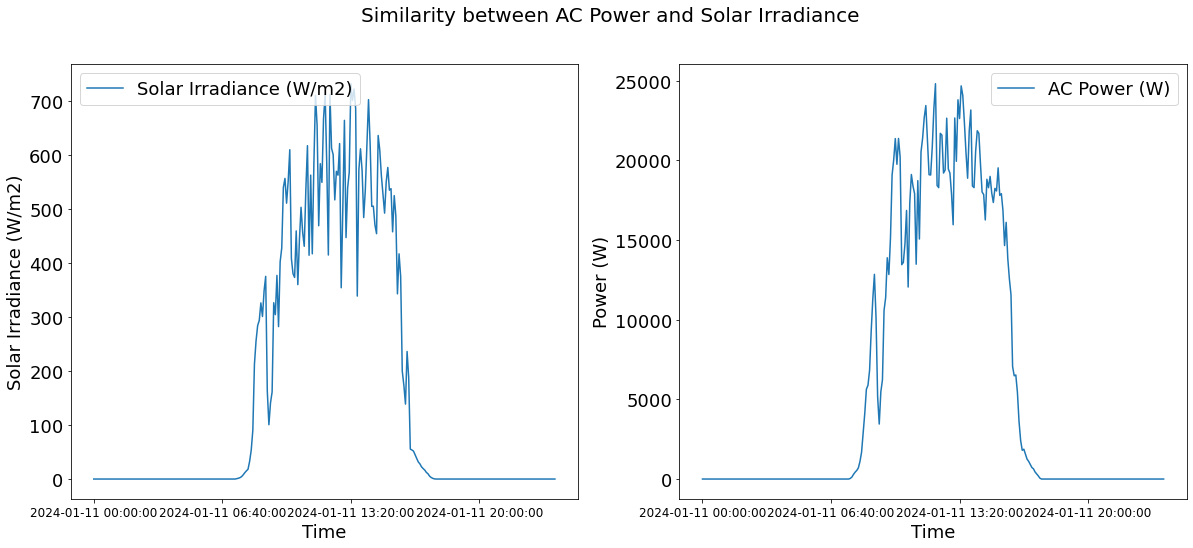

In [48]:
i = 10
num_locator = 5
from matplotlib.ticker import MaxNLocator
time_series_minute = sp_env_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['time'].values
ac_power = sp_op_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['ac_power'].values
ir = ae_df.iloc[ae_start_index[i]:ae_end_index[i]:interval]['GHI'].values

    
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.tick_params(axis='x', labelsize=12)  
ax1.tick_params(axis='y', labelsize=18)     
ax1.plot(time_series_minute, ir, label='Solar Irradiance (W/m2)')
ax1.xaxis.set_major_locator(MaxNLocator(num_locator))
ax1.set_ylabel('Solar Irradiance (W/m2)', fontsize=18)
ax1.set_xlabel('Time', fontsize=18)
ax1.legend(prop={'size': 18})

ax2 = fig.add_subplot(gs[0, 1])
ax2.tick_params(axis='x', labelsize=12)  
ax2.tick_params(axis='y', labelsize=18)    
ax2.plot(time_series_minute, ac_power, label= 'AC Power (W)')
ax2.xaxis.set_major_locator(MaxNLocator(num_locator))
ax2.set_ylabel('Power (W)', fontsize=18)
ax2.set_xlabel('Time', fontsize=18)
ax2.legend(prop={'size': 18})

fig.suptitle('Similarity between AC Power and Solar Irradiance', fontsize=20)
plt.savefig('Ir_AC.png', dpi=300)
plt.show()

2024-01-01


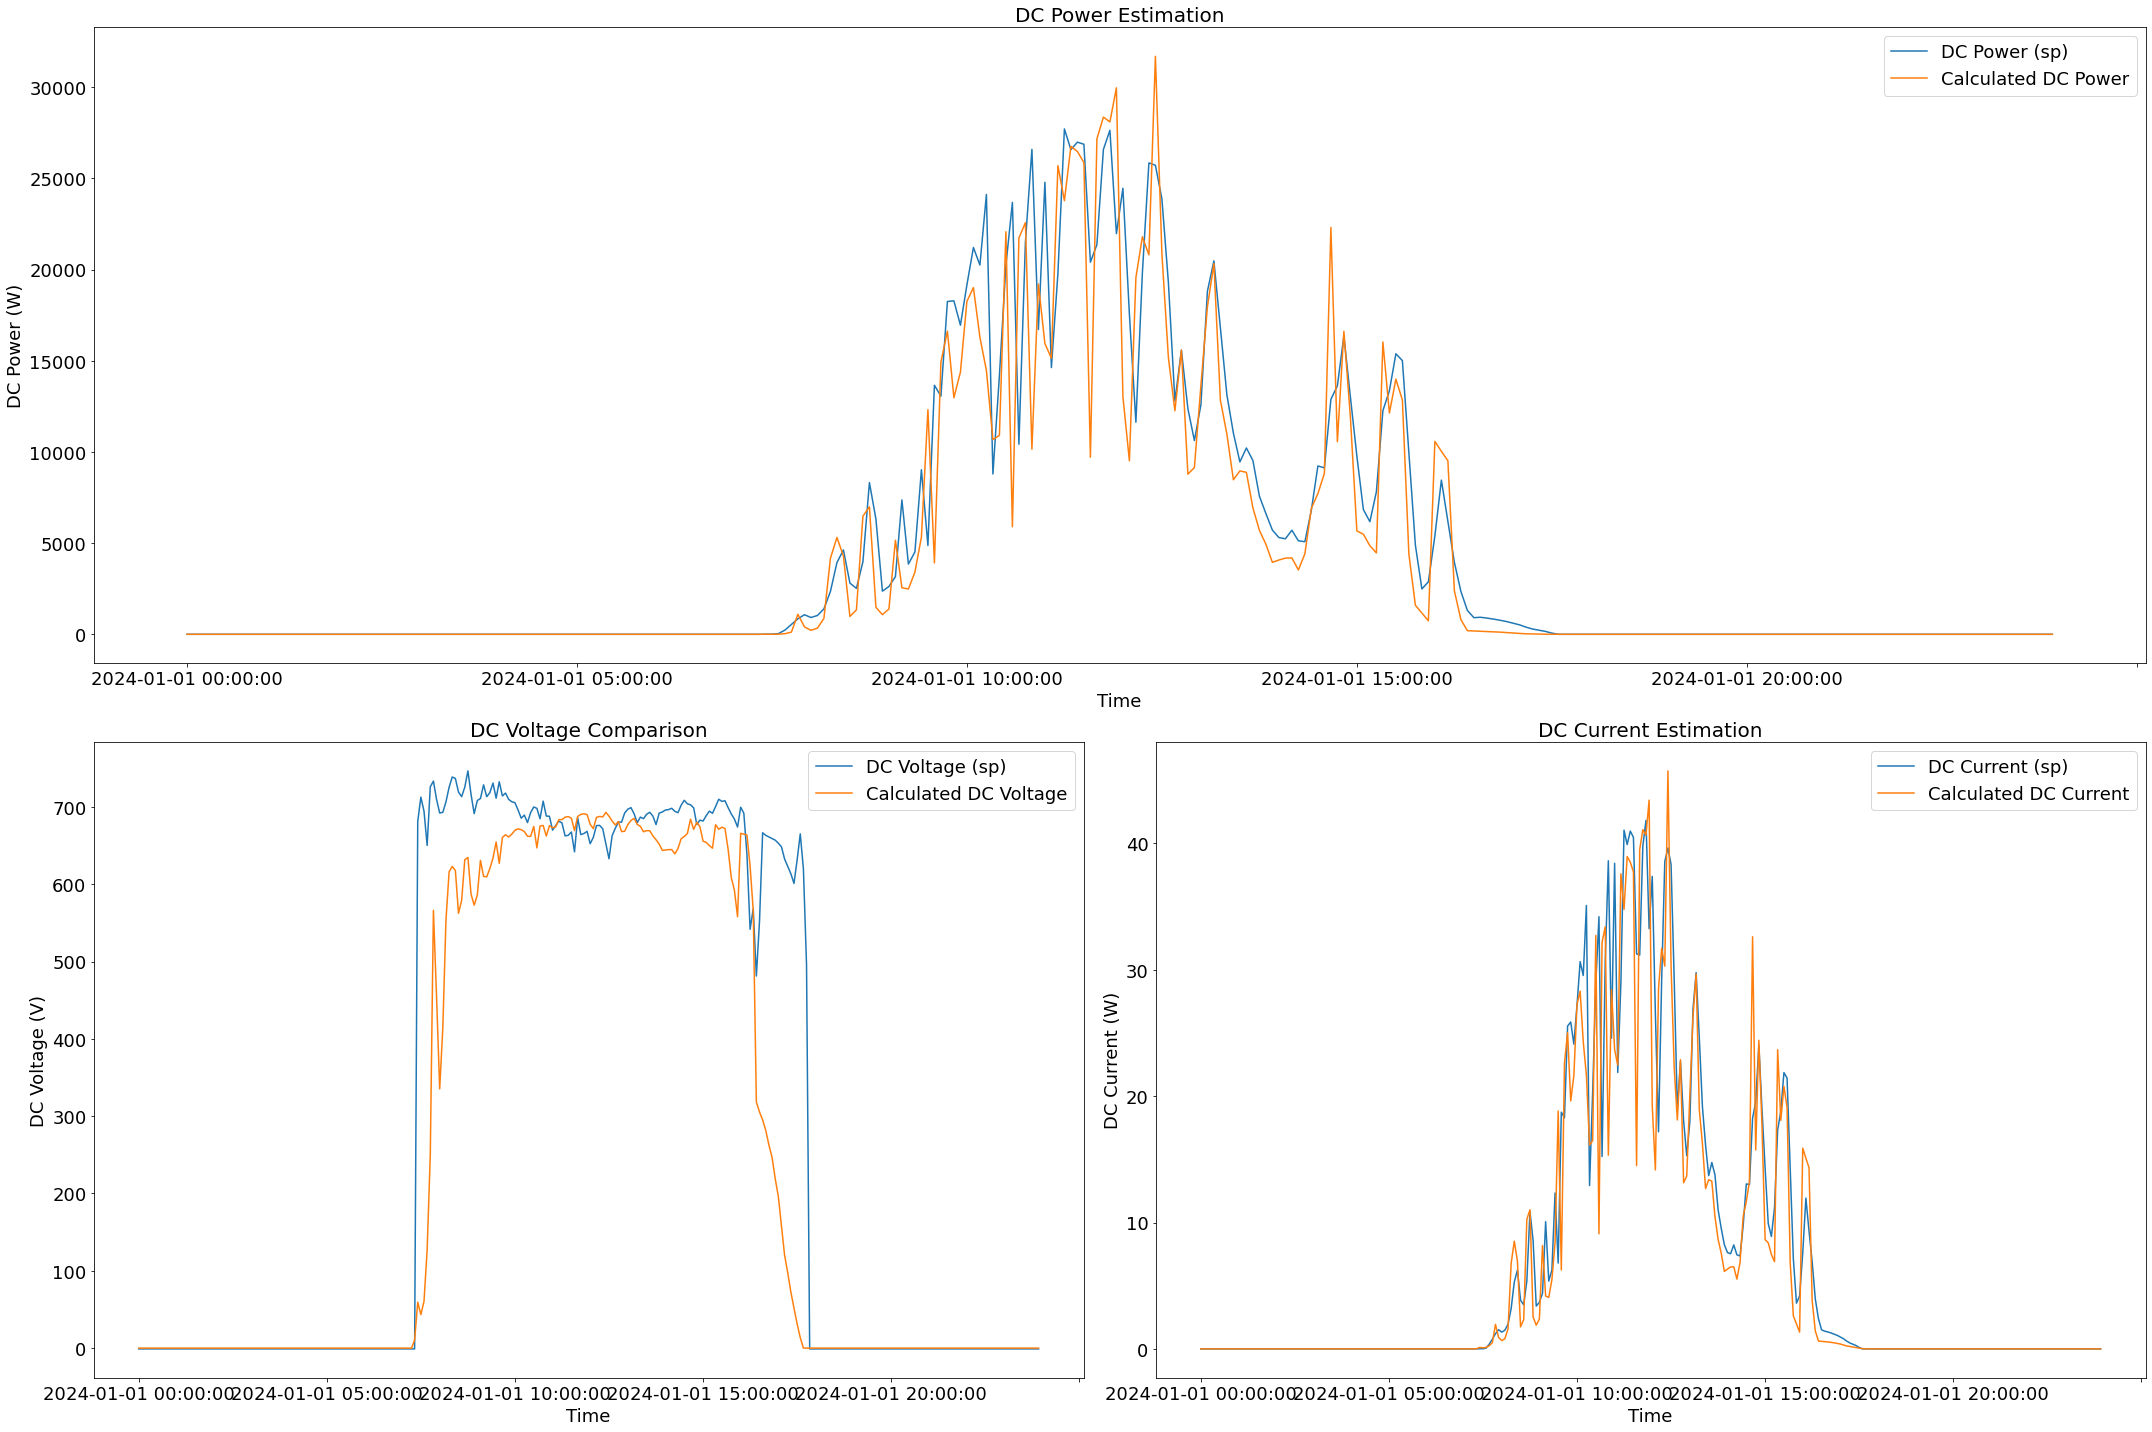

In [ ]:
happyliver1995
begin_idx = 0
for i in range(1):
    # Voltage: V[j] * pvCell.Nmodule 19
    # Current: I[j] * pvCell.Nstring 29
    curr_date = (start_date + timedelta(days=i)).strftime("%Y-%m-%d")
    time_series_hour = sp_env_df.iloc[sp_start_index[i] + int(sp_itv/2):sp_start_index[i]+sp_num_record[i]:sp_itv]['time'].values
    curr_ws_df = aligned_ws_df.iloc[ws_start_index[i]: ws_start_index[i] + ws_num_record[i]]
    time_series_minute = sp_env_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['time'].values
    dc_voltage = sp_op_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['dc_voltage_a'].values 
    dc_power = sp_op_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['dc_power_a'].values +  sp_op_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['dc_power_b'].values
    dc_current = sp_op_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['dc_current_a'].values +  sp_op_df.iloc[sp_start_index[i]:sp_start_index[i]+sp_num_record[i]]['dc_current_b'].values
    
    fig = plt.figure(figsize=(30, 20))
    gs = GridSpec(2, 2, figure=fig)
    
    print(curr_date)
    
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time_series_minute, dc_power, label='DC Power (sp)')
    ax1.plot(time_series_minute, ae_dc_power_calculated[begin_idx:begin_idx+sp_num_record[i]] / (pvCell.Nmodule * pvCell.Nstring) * (13 * 10), label='Calculated DC Power')
    ax1.tick_params(axis='x', labelsize=18)  
    ax1.tick_params(axis='y', labelsize=18) 
    ax1.set_xlabel('Time', fontsize=18)
    ax1.set_ylabel('DC Power (W)', fontsize=18)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(num_display)) 
    ax1.set_title("DC Power Estimation", fontsize=20)
    ax1.legend(prop={'size': 18})
    
    '''
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(time_series_hour, curr_ws_df['weather_points'], label='DC Power (sp)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Weather Points')
    ax2.xaxis.set_major_locator(plt.MaxNLocator(num_display)) 
    ax2.set_title("Weather Condition")
    ax2.legend()    
    '''

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(time_series_minute, dc_voltage, label='DC Voltage (sp)')
    ax3.plot(time_series_minute, ae_dc_voltage_calculated[begin_idx:begin_idx+sp_num_record[i]] / pvCell.Nmodule * 13, label='Calculated DC Voltage')
    ax3.tick_params(axis='x', labelsize=18)  
    ax3.tick_params(axis='y', labelsize=18) 
    ax3.set_xlabel('Time', fontsize=18)
    ax3.set_ylabel('DC Voltage (V)', fontsize=18)
    ax3.xaxis.set_major_locator(plt.MaxNLocator(num_display)) 
    ax3.set_title("DC Voltage Comparison", fontsize=20)
    ax3.legend(prop={'size': 18})

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(time_series_minute, dc_current, label='DC Current (sp)')
    ax4.plot(time_series_minute, ae_dc_current_calculated[begin_idx:begin_idx+sp_num_record[i]] / pvCell.Nstring * 10, label='Calculated DC Current')
    ax4.tick_params(axis='x', labelsize=18)  
    ax4.tick_params(axis='y', labelsize=18) 
    ax4.set_xlabel('Time', fontsize=18)
    ax4.set_ylabel('DC Current (W)', fontsize=18)
    ax4.xaxis.set_major_locator(plt.MaxNLocator(num_display)) 
    ax4.set_title("DC Current Estimation", fontsize=20)
    ax4.legend(prop={'size': 18})
    
    fig.tight_layout()
    plt.show()
    fig.savefig('plot/'+curr_date+'.png', dpi=100)
    
    begin_idx = begin_idx + sp_num_record[i]